# 🔍 Pipeline for TTD Newsletter

This notebook is used to find, test, and evaluate various methods and pipelines applied over articles.

In [2]:
import sys
import os
sys.path.append('../')
from ttd.storage.ttd_storage import TTDStorage
from ttd.pipelines.core import PredictStep, TransformStep, Pipeline
from ttd.utils.config import load_config
from dotenv import load_dotenv
from pprint import pprint
from pathlib import Path
from collections import Counter


load_dotenv()
OPEN_ROUTER_API_KEY = os.getenv("OPEN_ROUTER_API_KEY")
config = load_config()
DB_PATH = config["db_path"]

In [3]:
# load storage and articles
storage = TTDStorage(DB_PATH)
articles = storage.get_all("articles")
len(articles)

1199

## Scraped articles analysis

In [10]:
len(articles)

1199

In [11]:
articles[-1]

{'title': 'Detecting walking speed with wireless signals',
 'author': 'Anonymous',
 'published_date': 'Mon, 01 May 2017 14:25:29 +0000',
 'url_domain': 'csail.mit.edu',
 'url': 'https://www.csail.mit.edu/news/detecting-walking-speed-wireless-signals',
 'summary': 'Detecting walking speed with wireless signals Anonymous (not verified) Mon, 05/01/2017 - 10:25 \nVideo\nMay 01 \'17\nAdam Conner-Simons | Rachel Gordon\nWe’ve long known that blood pressure, breathing, body temperature and pulse provide an important window into the complexities of human health. But a growing body of research suggests that another vital sign – how fast you walk – could be a better predictor of health issues like cognitive decline, falls, and even certain cardiac or pulmonary diseases.\nWe’ve long known that blood pressure, breathing, body temperature and pulse provide an important window into the complexities of human health. But a growing body of research suggests that another vital sign –how fast you walk –c

In [12]:
for i, article in enumerate(articles[:50]):
    print(f"{i+1:2d}. {article.get('title', 'No title')}")

 1. Trump Tariffs Unleash Shift in Global Economy
 2. Intel CEO: ‘You Deserve Better, We Need To Improve and We Will’
 3. CHERIoT-Ibex Core is Open Sourced to Enable Memory Safe MCUs
 4. The Evolution of Optical Computing: Part 2
 5. GUC Announces Tape-Out of the World’s First HBM4 IP on TSMC N3P
 6. Lightmatter Unveils 3D Co-Packaged Optics for 256 Tbps in One Package
 7. Auto Tariffs Send Ripples Across Supply Chains – Part 2
 8. The Evolution of Optical Computing: Part 1
 9. How Did Nvidia Improve Hopper Inference Performance 30x?
10. OFC 2025 Debuts Terahertz Radio Over Wire, Coherent DSP and More
11. Announcing Native LLM APIs in Ray Data and Ray Serve
12. Introducing the Ray for Practitioners Course and Private Training from Anyscale
13. Announcing the Anyscale Technical Webinar Series: Learn Ray and Distributed AI
14. uv + Ray: Pain-Free Python Dependencies in Clusters
15. KubeRay v1.3.0: Enhancing Observability, Reliability, and Usability
16. Introducing the Ray Kubectl Plugin:

In [13]:
def print_domain_matches(rss_file_path: Path, domain_counts: Counter, label: str = ""):
    print(f"\n📄 Checking {label or rss_file_path.name}:")
    with rss_file_path.open("r") as file:
        for line in file:
            url = line.strip()
            if not url:
                continue
            domain = extract_domain(url)
            count = domain_counts.get(domain, 0)
            if count > 0:
                print(f"[✅] Found: {domain} ({count} article(s))")
            else:
                print(f"[❌] Not found: {domain}")

# Step 1: Count article domains
domains = [article['url_domain'] for article in articles if article.get('url_domain')]
domain_counts = Counter(domains)
print("There are", len(domain_counts), "non-empty domains.")

# Step 2: Paths to RSS files
rss_files = {
    "Regular RSS Feeds": Path("../data/rss_feeds.txt"),
    "Stealth RSS Feeds": Path("../data/rss_feeds_stealth.txt")
}

# Step 3: Check both files
for label, path in rss_files.items():
    print_domain_matches(path, domain_counts, label=label)

There are 31 non-empty domains.

📄 Checking Regular RSS Feeds:


NameError: name 'extract_domain' is not defined

In [ ]:
from collections import Counter

def print_field_coverage(articles):
    total = len(articles)
    if total == 0:
        print("No articles to process.")
        return

    field_counts = Counter()

    for article in articles:
        for field, value in article.items():
            if value not in (None, '', [], {}):
                field_counts[field] += 1

    print(f"\n📊 Field Coverage Report ({total} articles):\n")
    for field in sorted(field_counts):
        count = field_counts[field]
        percent = (count / total) * 100
        print(f"{field:20} : {count:4} / {total} ({percent:.1f}%)")

# Example usage
print_field_coverage(articles)


📊 Field Coverage Report (1199 articles):

author               :  588 / 1199 (49.0%)
created_at           : 1199 / 1199 (100.0%)
execution_time       : 1199 / 1199 (100.0%)
html_content_length  : 1199 / 1199 (100.0%)
html_content_path    : 1199 / 1199 (100.0%)
published_date       : 1199 / 1199 (100.0%)
summary              : 1182 / 1199 (98.6%)
summary_length       : 1199 / 1199 (100.0%)
summary_text_ratio   : 1199 / 1199 (100.0%)
tags                 :  561 / 1199 (46.8%)
text_content_length  : 1199 / 1199 (100.0%)
text_content_path    : 1199 / 1199 (100.0%)
title                : 1199 / 1199 (100.0%)
url                  : 1199 / 1199 (100.0%)
url_domain           : 1199 / 1199 (100.0%)


## Model Lifecycle

In [ ]:
# test model lifecycle
SUMMARY_PROMPT = '''You are a professional summarizer in an automated newsletter system.

Your task is to summarize the following article in **fewer than 250 words**. The summary must be **as concise and information-dense as possible**, while preserving all **essential facts, arguments, conclusions, and relevant keywords**.

Avoid: redundancy, filler phrases, vague language, or speculative commentary.  
Do: use clear, direct language and complete sentences. Maintain a **neutral and factual tone**.

ARTICLE: """
{text_content}
"""
'''
model = {
    "name": "test_deepseek-r1-distill-qwen-32b:free",
    "version": "2025-01-29",
    "input_format": "text_content",
    "output_format": "summary",
    "config": {
        "openai": {
            "base_url": "https://openrouter.ai/api/v1",
            "model": "deepseek/deepseek-r1-distill-qwen-32b:free",
            "api_key_env_var": "OPEN_ROUTER_API_KEY",
            "template": SUMMARY_PROMPT,
            "temperature": 0,
            "max_tokens": 5000,
            "n": 1
        }
    }
}
storage.save('models', model)

In [ ]:
model_dict = storage.get_by_field(
    "models",
    "name",
    "test_deepseek-r1-distill-qwen-32b:free"
)
model_dict["input_format"] = "text_content"
model_dict["max_tokens"] = 10000
storage.update("models", model_dict)

In [ ]:
model_dict = storage.get_by_field(
    "models",
    "name",
    "test_deepseek-r1-distill-qwen-32b:free"
)
pprint(model_dict)

{'config': {'openai': {'api_key_env_var': 'OPEN_ROUTER_API_KEY',
                       'base_url': 'https://openrouter.ai/api/v1',
                       'max_tokens': 5000,
                       'model': 'deepseek/deepseek-r1-distill-qwen-32b:free',
                       'n': 1,
                       'temperature': 0,
                       'template': 'You are a professional summarizer in an '
                                   'automated newsletter system.\n'
                                   '\n'
                                   'Your task is to summarize the following '
                                   'article in **fewer than 250 words**. The '
                                   'summary must be **as concise and '
                                   'information-dense as possible**, while '
                                   'preserving all **essential facts, '
                                   'arguments, conclusions, and relevant '
                                   'k

In [ ]:
pprint(model["model_instance"].template(text_content='HELLO WORLD'))

('You are a professional summarizer in an automated newsletter system.\n'
 '\n'
 'Your task is to summarize the following article in **fewer than 250 words**. '
 'The summary must be **as concise and information-dense as possible**, while '
 'preserving all **essential facts, arguments, conclusions, and relevant '
 'keywords**.\n'
 '\n'
 'Avoid: redundancy, filler phrases, vague language, or speculative '
 'commentary.  \n'
 'Do: use clear, direct language and complete sentences. Maintain a **neutral '
 'and factual tone**.\n'
 '\n'
 'ARTICLE: """\n'
 'HELLO WORLD\n'
 '"""\n')


In [ ]:
model = storage.load("model_instance", model_dict)
article = storage.load('text_content', articles[0])

input = {
    "text_content": article['text_content']
}
pprint(model["model_instance"].template(**input))

('You are a professional summarizer in an automated newsletter system.\n'
 '\n'
 'Your task is to summarize the following article in **fewer than 250 words**. '
 'The summary must be **as concise and information-dense as possible**, while '
 'preserving all **essential facts, arguments, conclusions, and relevant '
 'keywords**.\n'
 '\n'
 'Avoid: redundancy, filler phrases, vague language, or speculative '
 'commentary.  \n'
 'Do: use clear, direct language and complete sentences. Maintain a **neutral '
 'and factual tone**.\n'
 '\n'
 'ARTICLE: """\n'
 'designLines AI & Big Data Designline\n'
 'Trump Tariffs Unleash Shift in Global Economy\n'
 'Economists warn could yield higher prices, retaliation, and limited economic '
 'gains\n'
 'By Pablo Valerio 04.03.2025 __ 0\n'
 '__ Share Post\n'
 '__ Share on Facebook\n'
 '__ Share on Twitter\n'
 '__\n'
 'In a move signaling a decisive shift in global economic policy, under the '
 'International Emergency Economic Powers Act of 1977, United St

In [ ]:
model["model_instance"].predict(input)

{'output': 'President Trump has implemented new tariffs under the International Emergency Economic Powers Act of 1977, imposing a universal 10% tariff on all imports and higher reciprocal tariffs on 60 countries, including a 34% tariff on China. Effective April 5, these tariffs aim to correct unfair trade practices but have raised concerns about higher prices, retaliation, and limited economic benefits. Critics argue that tariffs may harm domestic consumers and businesses, leading to inflation and reduced competitiveness. The electronics sector, reliant on global supply chains, faces significant disruption, potentially increasing costs for consumers and forcing companies to restructure their operations. Retaliatory measures from trading partners could further harm U.S. exports. The tariffs signal a shift towards protectionism, with uncertain long-term effects on global trade and economic growth. Experts warn that such policies could lead to lower economic growth, higher prices, and red

In [ ]:
model_dict = storage.get_by_field(
    "models",
    "name",
    "test_deepseek-r1-distill-qwen-32b:free"
)
model = storage.load("model_instance", model)

Queries = [
    QueryInput(
        source="article",
        alias="article_1",
        data=list(map(lambda x: storage.load('text_content', x),
                         articles[:2]))
    )
#    ("article_2", list(map(lambda x: storage.load('text_content', x),
#                         articles[:2])))
]

pipe = Pipe(
    "article",
    Queries,
    model,
    storage
)
pipe.run(save=False)

[{'model_id': None,
  'task_type': 'summary',
  'created_at': '2025-04-08T09:51:35.269508',
  'execution_time': 6,
  'input_refs': {'article_1': {'table_name': 'article', 'doc_id': 1}},
  'pipe_name': 'article',
  'pipeline_name': None,
  'output': "U.S. President Donald Trump has implemented new tariffs under the International Emergency Economic Powers Act of 1977, introducing a 10% universal tariff and 10-50% reciprocal tariffs on 60 countries, including a 34% duty on China, raising total tariffs to 54%. Trump claims these tariffs correct unfair trade practices, but global leaders and economists warn of higher prices, inflation, and economic disruption. The European Commission's Ursula von der Leyen predicts significant harm, while China condemns the move as bullying. Critics argue tariffs hurt consumers and businesses, potentially lowering U.S. competitiveness and growth. The electronics sector faces supply chain disruptions, with companies likely facing higher costs and restructuri

## Summary Analysis


📊 Comparison of Content Sizes (top 50 by html_content length):
URL                                                |   HTML |   Text |  Summary
--------------------------------------------------------------------------------
https://www.theguardian.com/news/audio/2025/apr/03 | 296373 |   1169 |      867
https://www.theguardian.com/info/2016/sep/02/sign- | 248133 |    684 |      483
https://www.theguardian.com/environment/video/2025 | 392825 |    784 |      537
https://www.theguardian.com/world/video/2025/mar/0 | 289850 |   1187 |      805
https://www.theguardian.com/world/video/2025/mar/3 | 282707 |    975 |      661
https://www.theguardian.com/us-news/video/2025/apr | 291016 |    879 |      584
https://www.theguardian.com/global/2022/sep/20/sig | 258005 |    728 |      474
https://www.theguardian.com/us-news/video/2025/mar | 281361 |   1071 |      696
https://www.theguardian.com/world/video/2025/mar/0 | 281855 |    777 |      502
https://www.theguardian.com/environment/video/2025 | 28

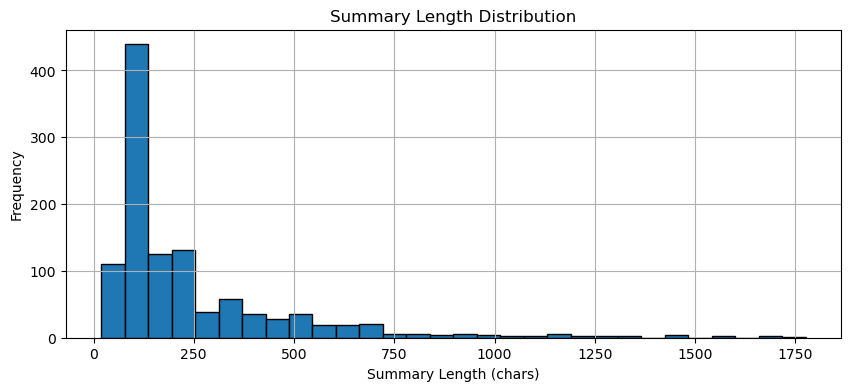

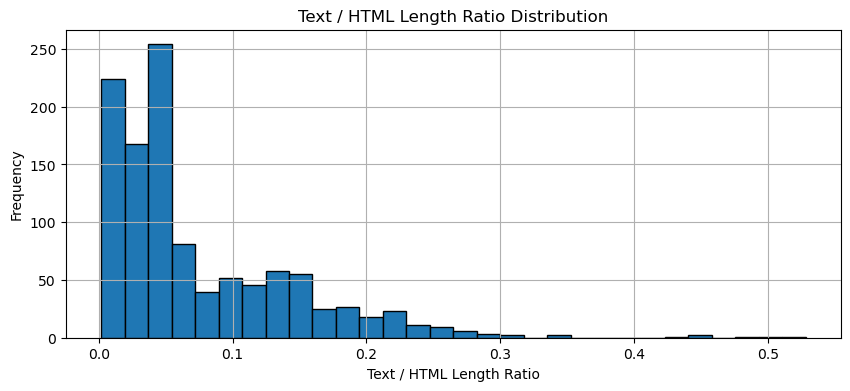

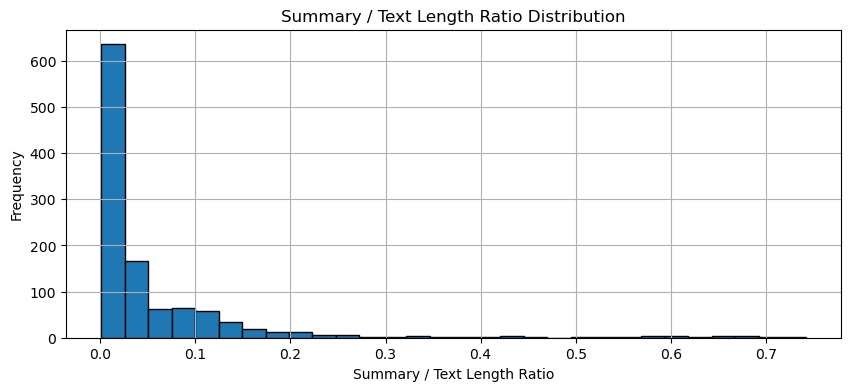

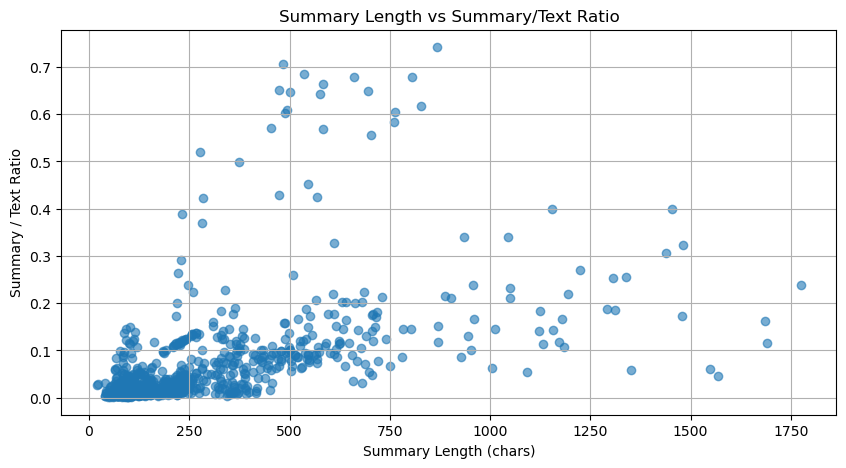

In [ ]:
import matplotlib.pyplot as plt

def compare_content_sizes(articles, storage):
    results = []
    summary_lengths = []
    text_html_ratios = []
    summary_text_ratios = []

    for article in articles:
        try:
            html = storage.from_article_get_html(article) or ""
            text = storage.from_article_get_text(article) or ""
            text = extract_markdown_from_html(storage.from_article_get_html(article))
            summary = article.get("summary", "") or ""
            summary = clean_markdown(summary)
            html_len = len(html)
            text_len = len(text)
            summary_len = len(summary)
            summary_text_ratio = summary_len / text_len

            if summary_text_ratio < 0.8:
                results.append({
                    "url": article.get("url"),
                    "html_len": html_len,
                    "text_len": text_len,
                    "summary_len": summary_len,
                    "summary_text_ratio": summary_len / text_len
                })
                
                if summary_len == 1000000:
                    print(article.doc_id)
                    pprint(article)

                if summary_len > 0 and html_len > 0 and text_len > 0:
                    summary_lengths.append(summary_len)
                    text_html_ratios.append(text_len / html_len)
                    summary_text_ratios.append(summary_len / text_len)

        except Exception as e:
            print(f"⚠️ Error processing article: {article.get('url')} - {e}")

    # Print comparison table
    results.sort(key=lambda x: x["summary_text_ratio"], reverse=True)
    print(f"\n📊 Comparison of Content Sizes (top 50 by html_content length):")
    print(f"{'URL':50} | {'HTML':>6} | {'Text':>6} | {'Summary':>8}")
    print("-" * 80)
    for r in results[:50]:
        print(f"{r['url'][:50]:50} | {r['html_len']:6} | {r['text_len']:6} | {r['summary_len']:8}")

    # Plot summary length distribution
    plt.figure(figsize=(10, 4))
    plt.hist(summary_lengths, bins=30, edgecolor='black')
    plt.title("Summary Length Distribution")
    plt.xlabel("Summary Length (chars)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    # Plot text/html ratio
    plt.figure(figsize=(10, 4))
    plt.hist(text_html_ratios, bins=30, edgecolor='black')
    plt.title("Text / HTML Length Ratio Distribution")
    plt.xlabel("Text / HTML Length Ratio")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    # Plot summary/text ratio
    plt.figure(figsize=(10, 4))
    plt.hist(summary_text_ratios, bins=30, edgecolor='black')
    plt.title("Summary / Text Length Ratio Distribution")
    plt.xlabel("Summary / Text Length Ratio")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    # Scatter plot: summary_length vs summary_text_ratio
    plt.figure(figsize=(10, 5))
    plt.scatter(summary_lengths, summary_text_ratios, alpha=0.6)
    plt.title("Summary Length vs Summary/Text Ratio")
    plt.xlabel("Summary Length (chars)")
    plt.ylabel("Summary / Text Ratio")
    plt.grid(True)
    plt.show()

    return results

results = compare_content_sizes(articles, storage)

In [ ]:
article = storage.get_article_by_url(results[500]['url'])
text_content = storage.from_article_get_text(article)
print(article['url'])
print(len(text_content))
pprint(text_content)

https://arstechnica.com/gadgets/2025/04/nvidia-confirms-the-switch-2-supports-dlss-g-sync-and-ray-tracing/
3225
('Text settings\n'
 'Story text\n'
 'Size Small Standard Large Width\n'
 'Standard Wide Links Standard Orange\n'
 'Subscribers only \n'
 'Learn more\n'
 'Minimize to nav\n'
 'In the wake of the Switch 2 reveal, neither Nintendo nor Nvidia has gone '
 'into any detail at all about the exact chip inside the upcoming '
 'handheld—technically, we are still not sure what Arm CPU architecture or '
 'what GPU architecture it uses, how much RAM we can expect it to have, how '
 "fast that memory will be, or exactly how many graphics cores we're looking "
 'at.\n'
 'But interviews with Nintendo executives and a blog post from Nvidia did at '
 'least confirm several of the new chip\'s capabilities. The "custom Nvidia '
 'processor" has a GPU "with dedicated [Ray-Tracing] Cores and Tensor Cores '
 'for stunning visuals and AI-driven enhancements," writes Nvidia Software '
 'Engineering V

In [ ]:
SUMMARY_PROMPT = '''You are a professional summarizer in an automated newsletter system.

Your task is to summarize the following article in **fewer than 250 words**. The summary must be **as concise and information-dense as possible**, while preserving all **essential facts, arguments, conclusions, and relevant keywords**.

Avoid: redundancy, filler phrases, vague language, or speculative commentary.  
Do: use clear, direct language and complete sentences. Maintain a **neutral and factual tone**.

ARTICLE: """
{text_content}
"""
'''

1314


## TAGs Analysis

In [ ]:
from collections import Counter

def count_all_tags(articles):
    tag_counter = Counter()
    for article in articles:
        tags = article.get("tags", [])
        if isinstance(tags, list):
            tag_counter.update(tags)
    return tag_counter

# Run and display
tag_counts = count_all_tags(articles)
print("There are ", len(tag_counts), "different tags :")
print("\n🏷️ Most Common Tags:")
for tag, count in tag_counts.most_common(100):  # change number to see more
    print(f"{tag:20} : {count}")

There are  1595 different tags :

🏷️ Most Common Tags:
LLMs                 : 66
NLP                  : 66
Data Development     : 63
AI                   : 57
Foundation Models    : 57
Fine-Tuning          : 52
Data Labeling        : 42
Applied AI           : 40
Artificial Intelligence : 38
World news           : 38
UK news              : 36
Data-Centric AI      : 35
Data development     : 33
Business             : 30
NEWS                 : 30
US news              : 29
Evaluation           : 29
Research             : 28
Donald Trump         : 26
Machine Learning     : 25
The-Latest           : 23
Product              : 23
News                 : 22
Alignment            : 22
Trump tariffs        : 21
AI News              : 21
Tariffs              : 19
Security             : 19
Culture              : 19
RAG                  : 18
GamesBeat            : 17
Environment          : 16
Life and style       : 16
Product Releases     : 16
Technology           : 15
Generative AI        : 15
Trump 

### Detect tags synonyms

In [ ]:
import os
import json
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# === Fake Embedding Function (for testing) ===
def fake_embedding_func(tags: list[str]) -> dict:
    rng = np.random.default_rng(seed=42)
    return {
        tag: rng.normal(size=384).tolist() for tag in tags
    }

# === Real OpenAI Embedding Function ===
def openai_embedding_func(tags: list[str]) -> dict:
    response = client.embeddings.create(
        input=tags,
        model="text-embedding-3-large"
    )
    return {
        tag: record.embedding
        for tag, record in zip(tags, response.data)
    }

# === Embedding Cache ===
def save_embeddings(path: str, embeddings: dict):
    with open(path, "w") as f:
        json.dump(embeddings, f)

def load_embeddings(path: str) -> dict:
    if os.path.exists(path):
        with open(path, "r") as f:
            return json.load(f)
    return {}

# === Synonym Detection ===
def find_strong_synonyms(
    tag_counts,              # dict or Counter: tag -> count
    embedding_func,
    threshold: float = 0.92,
    cache_path: str = None,
    lower: bool = True
):
    # 1. Normalize tag keys (lowercase if requested) and merge frequencies
    normalized_counts = {}
    original_forms = {}  # Maps normalized tag -> list of (original_tag, count)
    for tag, count in tag_counts.items():
        tag_key = tag.lower() if lower else tag
        normalized_counts[tag_key] = normalized_counts.get(tag_key, 0) + count
        original_forms.setdefault(tag_key, []).append((tag, count))

    tags = list(normalized_counts.keys())

    # 2. Load existing embeddings if available
    cached = load_embeddings(cache_path) if cache_path else {}
    tags_to_embed = [tag for tag in tags if tag not in cached]

    # 3. Embed only missing tags
    new_embeddings = embedding_func(tags_to_embed) if tags_to_embed else {}
    embeddings = {**cached, **new_embeddings}

    # 4. Optionally save updated cache
    if cache_path and new_embeddings:
        save_embeddings(cache_path, embeddings)

    # 5. Cosine similarity
    names = list(embeddings.keys())
    vectors = np.array([embeddings[name] for name in names])
    sim_matrix = cosine_similarity(vectors)

    # 6. Group synonyms
    tag_synonyms = []
    assigned_tags = set()

    for i, tag in enumerate(names):
        if tag in assigned_tags:
            continue

        group_members = [(tag, normalized_counts.get(tag, 1))]
        for j, other_tag in enumerate(names):
            if i != j and other_tag not in assigned_tags and sim_matrix[i][j] >= threshold:
                group_members.append((other_tag, normalized_counts.get(other_tag, 1)))
                assigned_tags.add(other_tag)

        # Sort members by count to determine the most frequent as the name
        group_members = sorted(group_members, key=lambda x: -x[1])
        main_tag, main_count = group_members[0]
        synonyms = [
            {"tag": tag_, "count": count_} 
            for tag_, count_ in group_members[1:]
        ]

        tag_synonyms.append({
            "name": main_tag,
            "count": main_count,
            "synonyms": synonyms
        })
        assigned_tags.update(tag_ for tag_, _ in group_members)

    return tag_synonyms

client = openai.OpenAI()  # Automatically uses OPENAI_API_KEY from env

CACHE_PATH = "../research/open_ai_embeddings_large_cache.json"
tags = tag_counts.most_common(1000)
test_tags = map(lambda x: x[0], tags)
fake_results = find_strong_synonyms(
    tag_counts,
    openai_embedding_func,
    threshold=0.6,
    cache_path=CACHE_PATH,
    lower=False
)
for group in fake_results:
    print(group)

{'name': 'LLMs', 'count': 66, 'synonyms': [{'tag': 'LLMOps', 'count': 12}, {'tag': 'LLM', 'count': 5}, {'tag': 'llms', 'count': 1}, {'tag': 'llmops', 'count': 1}, {'tag': 'llm', 'count': 1}, {'tag': 'LLaMA', 'count': 1}, {'tag': 'Llm', 'count': 1}]}
{'name': 'NLP', 'count': 66, 'synonyms': [{'tag': 'natural language processing', 'count': 3}, {'tag': 'nlp', 'count': 1}]}
{'name': 'Data Development', 'count': 63, 'synonyms': [{'tag': 'Data development', 'count': 33}, {'tag': 'data development', 'count': 1}, {'tag': 'data management', 'count': 1}, {'tag': 'developer skills', 'count': 1}, {'tag': 'web development', 'count': 1}, {'tag': 'software development', 'count': 1}]}
{'name': 'AI', 'count': 57, 'synonyms': [{'tag': 'ai', 'count': 1}, {'tag': 'ai model', 'count': 1}]}
{'name': 'Foundation Models', 'count': 57, 'synonyms': [{'tag': 'foundation models', 'count': 1}, {'tag': 'foundation model', 'count': 1}]}
{'name': 'Fine-Tuning', 'count': 52, 'synonyms': [{'tag': 'fine-tuning', 'count'

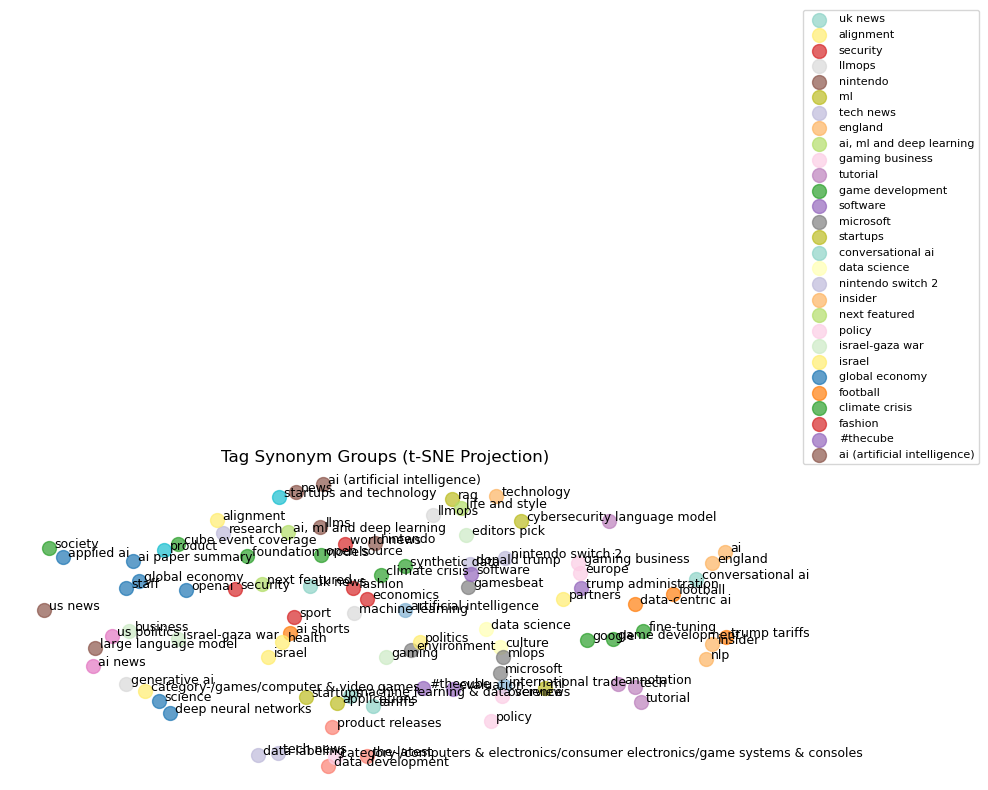

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import random

def plot_tag_synonym_groups(embeddings: dict, groups: list[dict]):
    """
    embeddings: dict of tag -> list of floats (vectors)
    groups: list of dicts with keys 'name' and 'synonyms'
    """
    tags = list(embeddings.keys())
    vectors = np.array([embeddings[tag] for tag in tags])

    # Reduce to 2D for visualization
    tsne = TSNE(n_components=2, random_state=42, perplexity=5)
    reduced = tsne.fit_transform(vectors)

    # Map tag -> 2D point
    coords = {tag: point for tag, point in zip(tags, reduced)}

    # Assign group colors
    group_map = {}
    color_map = {}
    color_pool = plt.cm.tab10.colors + plt.cm.Set3.colors

    for i, group in enumerate(groups):
        root = group['name']
        color = color_pool[i % len(color_pool)]
        for synonym in group['synonyms'] + [root]:
            group_map[synonym] = root
            color_map[root] = color

    # Plot
    plt.figure(figsize=(10, 8))
    for tag, point in coords.items():
        root = group_map.get(tag, tag)
        color = color_map.get(root, "gray")
        plt.scatter(*point, color=color, label=root if tag == root else "", s=100, alpha=0.7)
        plt.text(point[0]+0.5, point[1], tag, fontsize=9)

    plt.title("Tag Synonym Groups (t-SNE Projection)")
    plt.axis("off")
    plt.legend(loc='best', fontsize=8, bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

plot_tag_synonym_groups(embeddings=load_embeddings(CACHE_PATH), groups=fake_results)

## Date Analysis

/var/folders/1v/sjp4tylx5bb0fh0c4hfq_71r0000gn/T/ipykernel_1464/3775061812.py:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(freq="4M"), "domain"])
2025-04-22 18:51:20,895 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-04-22 18:51:20,896 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-04-22 18:51:20,899 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-04-22 18:51:20,900 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/Users/mathieucrilout/.miniconda3/envs/ttd/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-04-22 18:51:20,900 - matplotlib.font_man

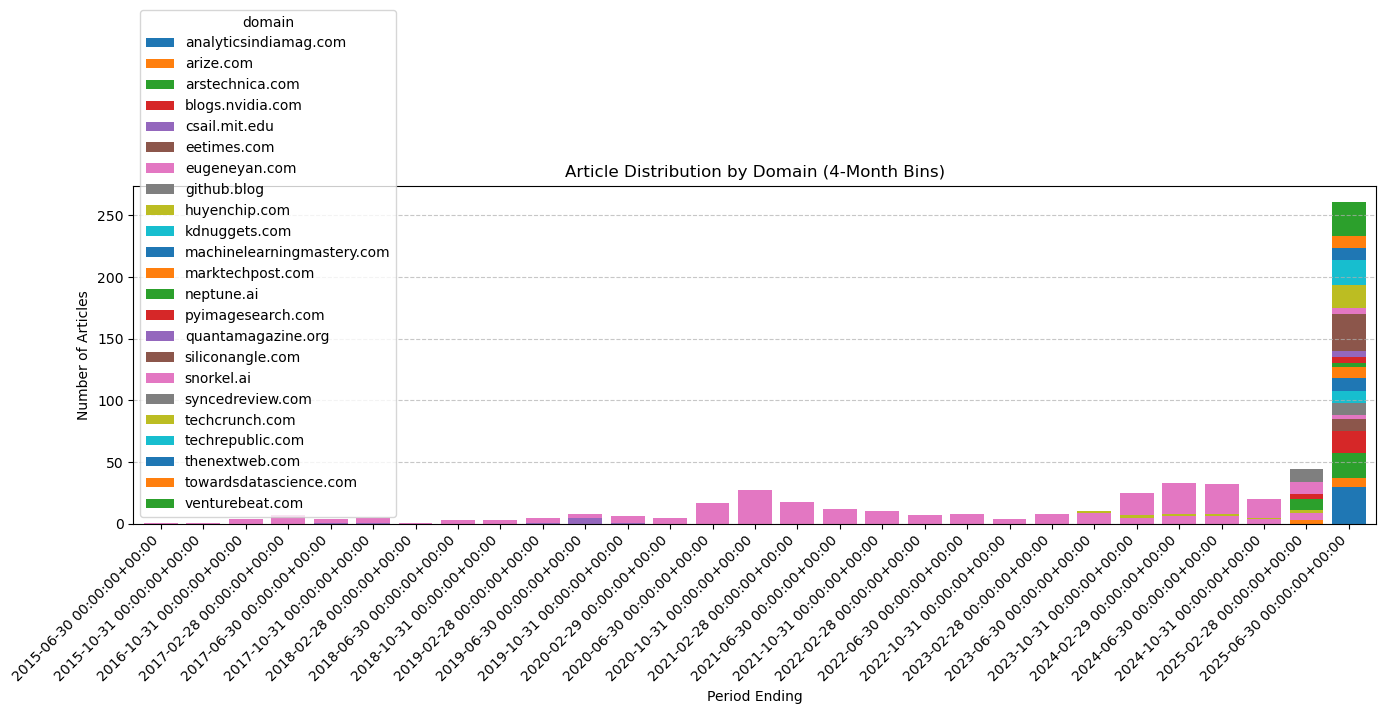

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def plot_article_distribution_by_domain_every_4_months(articles: list):
    # Extract relevant fields and parse dates
    records = []
    for art in articles:
        date_str = art.get("published_date")
        domain   = art.get("url_domain", "unknown")
        try:
            dt = datetime.strptime(date_str, "%a, %d %b %Y %H:%M:%S %z")
            records.append({"date": dt, "domain": domain})
        except Exception:
            # skip malformed dates
            continue

    # Build DataFrame and set date index
    df = pd.DataFrame(records)
    df.set_index("date", inplace=True)

    # Group by 4-month bins and domain
    # '4M' means calendar‑month frequency of 4 months
    grouped = (
        df
        .groupby([pd.Grouper(freq="4M"), "domain"])
        .size()
        .unstack(fill_value=0)
    )

    # Plot
    ax = grouped.plot(
        kind="bar",
        stacked=True,
        figsize=(14, 6),
        width=0.8,        # narrow bars
    )
    ax.set_title("Article Distribution by Domain (4‑Month Bins)")
    ax.set_xlabel("Period Ending")
    ax.set_ylabel("Number of Articles")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

plot_article_distribution_by_domain_every_4_months(articles)

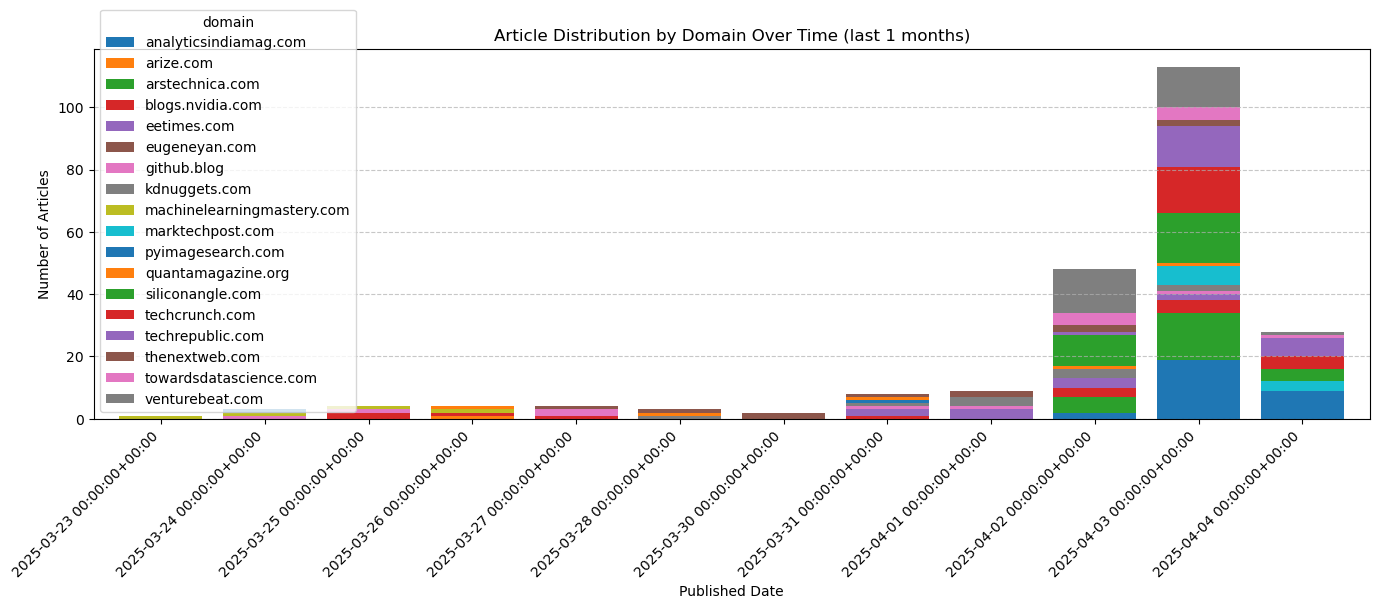

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta

def plot_article_distribution_by_domain_over_time(
    articles: list,
    n_months: int = None
):
    # 1) Parse dates and collect records
    records = []
    for art in articles:
        date_str = art.get("published_date")
        domain   = art.get("url_domain", "unknown")
        try:
            dt = datetime.strptime(date_str, "%a, %d %b %Y %H:%M:%S %z")
            records.append({"date": dt, "domain": domain})
        except Exception:
            continue

    # 2) Build DataFrame
    df = pd.DataFrame(records)
    if df.empty:
        print("No valid dates found.")
        return

    # 3) Filter to last n_months if requested
    if n_months is not None:
        cutoff = datetime.now(df["date"].dt.tz) - relativedelta(months=n_months)
        df = df[df["date"] >= cutoff]
        if df.empty:
            print(f"No articles in the last {n_months} months.")
            return

    # 4) Group and plot
    df.set_index("date", inplace=True)
    grouped = df.groupby([pd.Grouper(freq="D"), "domain"]).size().unstack(fill_value=0)

    ax = grouped.plot(
        kind="bar",
        stacked=True,
        figsize=(14, 6),
        width=0.8
    )
    subtitle = f" (last {n_months} months)" if n_months is not None else ""
    ax.set_title(f"Article Distribution by Domain Over Time{subtitle}")
    ax.set_xlabel("Published Date")
    ax.set_ylabel("Number of Articles")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

plot_article_distribution_by_domain_over_time(articles, n_months=1)

## Basic experiments

In [13]:
model_dict = storage.get_model_by_name("deepseek-r1-distill-qwen-32b:free")
pprint(model_dict)

{'config': {'openai': {'api_key_env_var': 'OPEN_ROUTER_API_KEY',
                       'base_url': 'https://openrouter.ai/api/v1',
                       'model': 'deepseek/deepseek-r1-distill-qwen-32b:free',
                       'n': 1,
                       'temperature': 0}},
 'created_at': '2025-04-01T20:03:35.982601',
 'input_format': 'text_content',
 'last_updated': '2025-04-02T17:19:03.810618',
 'name': 'deepseek-r1-distill-qwen-32b:free',
 'output_format': 'summary',
 'version': '2025-01-29'}
